In [1]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt

In [2]:
device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
fashion = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=False)
test = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=False)
batch_size=256

In [4]:
from cnn import CNN

In [6]:
trainloader = torch.utils.data.DataLoader(dataset=fashion, batch_size=128, shuffle=False)
testloader = torch.utils.data.DataLoader(dataset=test, batch_size=128, shuffle=False)

In [8]:
def load_subset(idx):
    f_path = f'subsets/split_{idx}'
    with open(f_path, 'rb') as f:
        subset = np.load(f)
    return subset

In [9]:
def load_model(idx):
    f_path = f'models/split_{idx}'
    model = CNN(10)
    model.load_state_dict(torch.load(f_path, weights_only=True))
    model.to(device)
    return model

In [10]:
def get_correctness_for_model(model):
    model.eval()
    trainset_correctness = []
    with torch.no_grad():
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            correctness = (predicted == targets).float()
            trainset_correctness.append(correctness)
    
    trainset_correctness = torch.cat(trainset_correctness).cpu()
    return trainset_correctness

In [12]:
def get_correctness():
    results = []
    for idx in range(2000):
        if (idx+1) % 100 == 0:
            print(f'Loading results for idx {idx+1}...')
        subset_idx = load_subset(idx)
        mask = np.zeros(len(fashion), dtype=bool)
        mask[subset_idx] = True
        model = load_model(idx)
        correctness = get_correctness_for_model(model)
        results.append((mask, correctness))
    
    mask_matrix = np.vstack([ret[0] for ret in results])
    correctness_matrix = np.vstack([ret[1] for ret in results])

    return mask_matrix, correctness_matrix

In [ ]:
trainset_mask, trainset_correctness = get_correctness()
with open('correctness.npy', 'wb') as f:
    np.save(f, trainset_correctness)
with open('trainset_mask.npy', 'wb') as f:
    np.save(f, trainset_mask)

Loading results for idx 100...


In [7]:
trainset_mask, trainset_correctness = np.load('trainset_mask.npy'), np.load('correctness.npy')

In [6]:
inv_mask = np.logical_not(trainset_mask)

In [7]:
def masked_avg(x, mask, axis=0, esp=1e-10):
    return (np.sum(x * mask, axis=axis) / np.maximum(np.sum(mask, axis=axis), esp)).astype(np.float32)

In [8]:
mem_est = masked_avg(trainset_correctness, trainset_mask) - masked_avg(trainset_correctness, inv_mask)
mem_est

array([ 0.023     ,  0.02399999, -0.00300002, ...,  0.02399999,
        0.01800001,  0.00600001], shape=(60000,), dtype=float32)

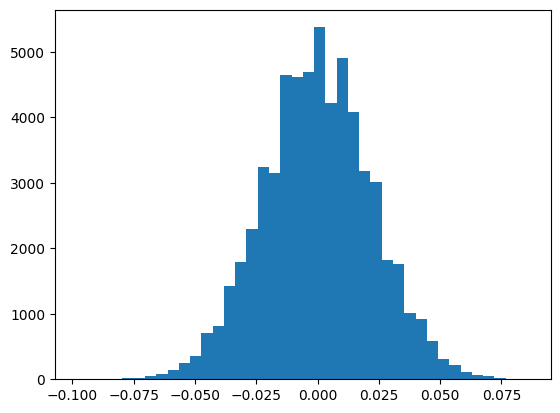

In [ ]:
plt.hist(mem_est, bins=40)
plt.show()

In [10]:
np.max(mem_est)

np.float32(0.085999995)

In [2]:
with open('infl_mem.npz', 'rb') as f:
    feldman_dict = np.load('infl_mem.npz')

In [5]:
feldman_memorization = feldman_dict['memorization']

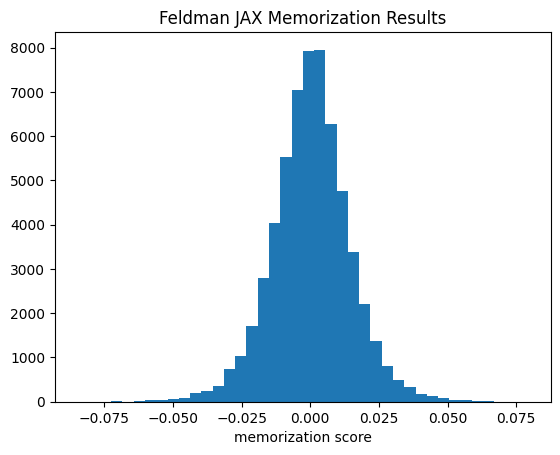

In [10]:
plt.hist(feldman_memorization, bins=40)
plt.title('Feldman JAX Memorization Results')
plt.xlabel('memorization score')
plt.show()